Source: https://github.com/heyad/Eng_Diagrams/blob/master/notebook/CNN_Eng_Drawings.ipynb

In [1]:
pwd

'/home/jovyan/mezcla/Documents/Data_Science/capstone/pid-digitization'

**Symbols in Engineering Drawings**

* Convolutional Neural Network for Multiclass Imbalanced Dataset Classication of Symbols in Engineering Drawings
* EANN 2020

# Loading symbols files

* Load necessary libraries
* Read the file (pixels of symbols)




In [1]:
%matplotlib inline 
import numpy as np # linear algebra
import pandas as pd #CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from random import randint
# imports for array-handling and plotting
import matplotlib
matplotlib.use('agg')
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from subprocess import check_output
%matplotlib inline
# hide warnings 
import warnings
warnings.filterwarnings('ignore')

# solve cudNN initialisation 
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# spit circles and crop images
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import imutils

# Quick Exploratory Data Analysis (EDA)

* Show first few rows
* Column names
* Shape (dimension of the dataframe)



In [2]:
ls data

pid.png  symbols_blog_projectmaterials/  Symbols_pixel.csv  symbols.png


In [3]:
df =pd.read_csv('data/Symbols_pixel.csv')

df.head()
df.columns
df.shape

(2431, 10001)

## Generate headers names

* This might not be necessary
* Just for clarity



In [4]:
# get the number df's columns
num_cols = df.shape[1]

# generate range of ints for suffixes
# with length exactly half that of num_cols;
# if num_cols is even, truncate concatenated list later
# to get to original list length
rng = range(1, (num_cols))

new_cols =  ['p_' + str(i) for i in rng]
new_cols.append('label')
# ensure the length of the new columns list is equal to the length of df's columns
df.columns = new_cols[:num_cols]
df.columns

Index(['p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10',
       ...
       'p_9992', 'p_9993', 'p_9994', 'p_9995', 'p_9996', 'p_9997', 'p_9998',
       'p_9999', 'p_10000', 'label'],
      dtype='object', length=10001)

## Data and Labels

* IF needed, Might want to separate labels from feature
* This resturns data into Panas Series



In [5]:
# extract labels (all rows, and last column)
n = df.shape[1] # number of columns 
labels =df['label']

features= df.iloc[:,0:n-1]
type(labels)

pandas.core.series.Series

In [6]:
type(features)

pandas.core.frame.DataFrame

In [7]:
features.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_9991,p_9992,p_9993,p_9994,p_9995,p_9996,p_9997,p_9998,p_9999,p_10000
0,255,255,255,255,255,255,255,255,255,255,...,255,255,0,0,0,0,0,0,0,0
1,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,255,255,255
2,255,255,255,255,255,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,255,255,255,...,255,255,255,255,255,255,255,255,255,255


## Show some random symbols (EDA)

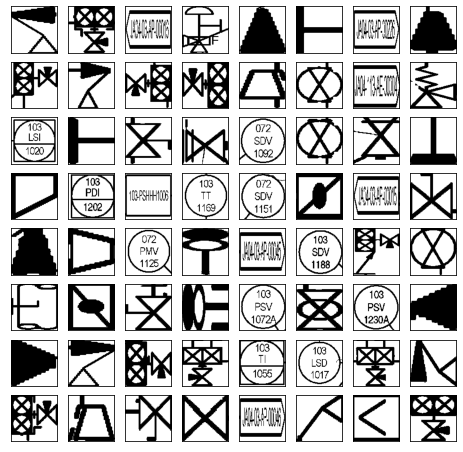

In [8]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
fx = features.values # returns numpy array

for i, axi in enumerate(ax.flat):
    value = randint(0, df.shape[0])
    axi.imshow(fx[value].reshape(100,100), cmap='gray')
    axi.set(xticks=[], yticks=[])

## Class distribution

* An extremly imbalanced problem

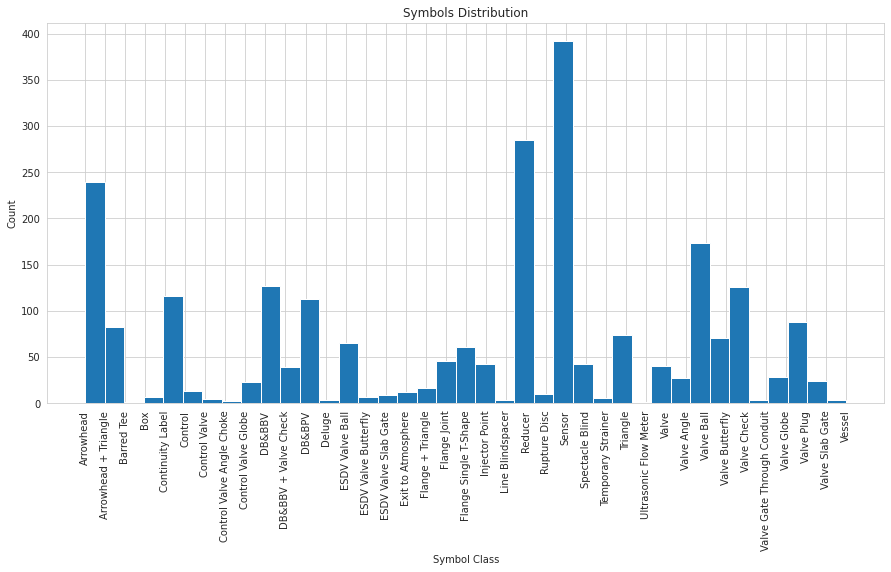

In [9]:
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))

plt.hist(labels,bins=39)
plt.title('Symbols Distribution')
plt.xlabel('Symbol Class')
plt.ylabel('Count')

plt.xticks(rotation=90)
plt.show()

## Check and remove least frequent symbols

* Some classes rarely appear
* and needs to be removed,
* first check the numbers



In [10]:
## check class distribution 
df['label'].value_counts()

Sensor                        392
Reducer                       285
Arrowhead                     239
Valve Ball                    173
DB&BBV                        127
Valve Check                   126
Continuity Label              116
DB&BPV                        113
Valve Plug                     88
Arrowhead + Triangle           83
Triangle                       74
Valve Butterfly                71
ESDV Valve Ball                65
Flange Single T-Shape          61
Flange Joint                   46
Injector Point                 43
Spectacle Blind                42
Valve                          40
DB&BBV + Valve Check           39
Valve Globe                    28
Valve Angle                    27
Valve Slab Gate                24
Control Valve Globe            23
Flange + Triangle              17
Control                        13
Exit to Atmosphere             12
Rupture Disc                   10
ESDV Valve Slab Gate            9
Box                             7
ESDV Valve But

## Remove symbols with less than 7 instances in the dataset

In [11]:
df = df[~df['label'].isin(['Ultrasonic Flow Meter', 'Barred Tee','Temporary Strainer',
                     'Control Valve Angle Choke','Line Blindspacer',
                     'Vessel','Valve Gate Through Conduit','Deluge','Control Valve'])]

df['label'].value_counts()

Sensor                   392
Reducer                  285
Arrowhead                239
Valve Ball               173
DB&BBV                   127
Valve Check              126
Continuity Label         116
DB&BPV                   113
Valve Plug                88
Arrowhead + Triangle      83
Triangle                  74
Valve Butterfly           71
ESDV Valve Ball           65
Flange Single T-Shape     61
Flange Joint              46
Injector Point            43
Spectacle Blind           42
Valve                     40
DB&BBV + Valve Check      39
Valve Globe               28
Valve Angle               27
Valve Slab Gate           24
Control Valve Globe       23
Flange + Triangle         17
Control                   13
Exit to Atmosphere        12
Rupture Disc              10
ESDV Valve Slab Gate       9
Box                        7
ESDV Valve Butterfly       7
Name: label, dtype: int64

# Neural Networks (CNNs)

* Prepare the dataset
* check the shapes


In [12]:
# labels and features (separate data frames)
# retrieve numpy array (to meet keras requirements )
dataset = df.values
# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]

print(X.shape)
print(y.shape)

(2400, 10000)
(2400,)


In [13]:
# check number of labels
print(f'There are {len(df.label.unique())} Unique Symbol in the dataset') 

There are 30 Unique Symbol in the dataset


## Prepare the data for the model

* Check the shapes of the input
* Split the data into train/ test subsets
* Reshape the data
* Prepare targets (labels)

In [14]:
from sklearn.model_selection import train_test_split

# simple functions to check the shapes of all components of the dataset 
# (train, test, labels)
def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)
    
# split the data and check the shapes of results sets  
# train_test_split(...) returns numpy arrays 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20)
data_summary(X_train,y_train,X_test,y_test)

Train images shape: (1920, 10000)
Train labels shape: (1920,)
Test images shape: (480, 10000)
Test labels shape: (480,)


**Prepare the data for the model**

* Reshape the data
* Prepare targets (labels)
* Check shape of the arrays before and after

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils


print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 100,100,1)
X_test = X_test.reshape(X_test.shape[0], 100,100,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


print('___ AFTER RESHAPE________')
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)

X_train  (1920, 10000)
y_train  (1920,)
X-test  (480, 10000)
y_test  (480,)
___ AFTER RESHAPE________
X_train  (1920, 100, 100, 1)
y_train  (1920,)
X-test  (480, 100, 100, 1)
y_test  (480,)


**Prepare the data for the model**
* Prepare targets (labels)
* String labels have to be encoded first



In [16]:
# Encode target variables 
# prepare target
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

y_train_cat = y_train
y_test_cat = y_test

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train,y_test)

print('y_train ',y_train.shape)
print('y_test ',y_test.shape)

y_train  (1920,)
y_test  (480,)


## Encode Labels Data

* Notice how the shape of the arrays changes



In [17]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print('y_train ',y_train.shape)
print('y_test ',y_test.shape)

y_train  (1920, 30)
y_test  (480, 30)


## Validation Set

In [18]:
# shuffle the training dataset (5 times!)

for _ in range(5): 
    indexes = np.random.permutation(len(X_train))

X_train = X_train[indexes]
y_train = y_train[indexes]

# Keep 10% of the training data for validation 
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(X_train))

# Validation set (val_data)
val_data = X_train[:val_count,:]
val_labels_cat = y_train[:val_count,:]


## Build Model

In [19]:
def build_modelU():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, 
                     kernel_size=(3,3), 
                     activation='relu', 
                     padding='same',
                     input_shape=(100, 100, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     activation='relu', 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3), 
                     activation='relu', 
                     padding='same'))
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3), 
                     activation='relu', 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_modelU()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 128)       1

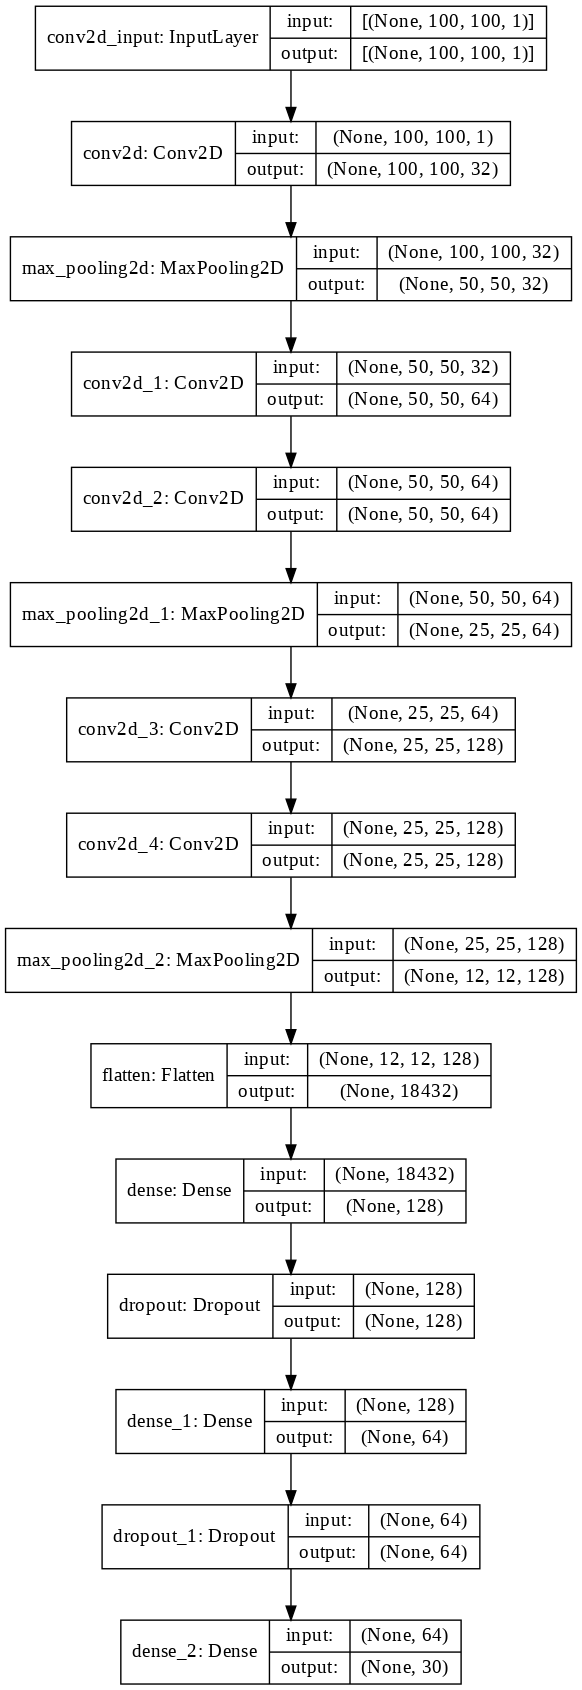

In [20]:
# plot graph with model's architecture

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, dpi=100)
# fig.savefig('model.png', dpi = 150)

## Results

In [21]:
nEpochs = 25 
results = model.fit(X_train, y_train, 
                    epochs=nEpochs, batch_size=64,
                    validation_data=(val_data, val_labels_cat))

Epoch 1/25
30/30 [==============================] - 186s 5s/step - loss: 11.1216 - accuracy: 0.1014 - val_loss: 2.1217 - val_accuracy: 0.4635
Epoch 2/25
30/30 [==============================] - 188s 6s/step - loss: 2.2624 - accuracy: 0.3725 - val_loss: 1.5228 - val_accuracy: 0.5729
Epoch 3/25
30/30 [==============================] - 220s 7s/step - loss: 1.7608 - accuracy: 0.4784 - val_loss: 1.2182 - val_accuracy: 0.7396
Epoch 4/25
30/30 [==============================] - 250s 8s/step - loss: 1.5082 - accuracy: 0.5617 - val_loss: 0.8680 - val_accuracy: 0.7969
Epoch 5/25
30/30 [==============================] - 170s 6s/step - loss: 1.3282 - accuracy: 0.6090 - val_loss: 0.7129 - val_accuracy: 0.8125
Epoch 6/25
30/30 [==============================] - 182s 6s/step - loss: 1.0775 - accuracy: 0.6735 - val_loss: 0.6111 - val_accuracy: 0.8385
Epoch 7/25
30/30 [==============================] - 185s 6s/step - loss: 1.0285 - accuracy: 0.6834 - val_loss: 0.5024 - val_accuracy: 0.8333
Epoch 8/25
3

## Check results

In [22]:
history_dict = results.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [23]:
# accuracy, test 
test_loss, test_accuracy = \
  model.evaluate(X_test, y_test, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))


8/8 [==============================] - 8s 889ms/step - loss: 0.2112 - accuracy: 0.9458
Test loss: 0.2112 accuracy: 0.9458


## Make predictions

In [24]:
predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
print('Accuracy: ',sum(preds==actuals)/X_test.shape[0])

Accuracy:  0.9458333333333333


In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
#print(confusion_matrix(preds,actuals))

# correctly identified symbols 
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != \
                        np.argmax(y_test,axis=1)).sum())

Test accuracy: 0.9458333253860474
Incorrectly Identified Symbols:  26


In [26]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

predictions = model.predict(X_train)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_train,axis=1)
#print(confusion_matrix(preds,actuals))

# correctly identified symbols 
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != \
                        np.argmax(y_train,axis=1)).sum())

Train loss: 0.06270406395196915
Train accuracy: 0.989062488079071
Incorrectly Identified Symbols:  21


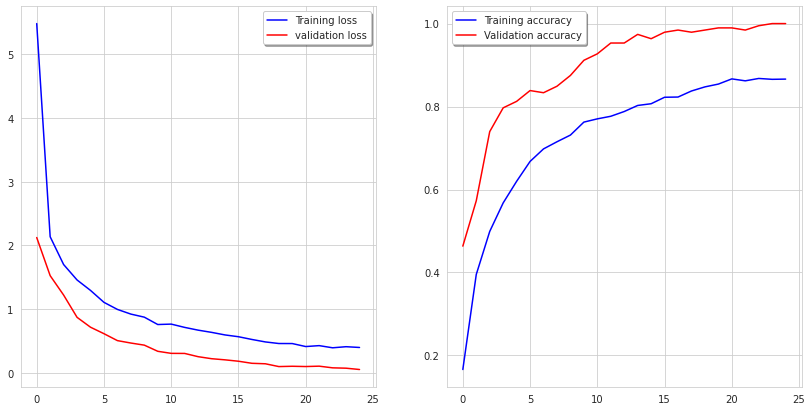

In [27]:
# Plot the loss and accuracy curves for training and validation 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].plot(results.history['loss'], color='b', label="Training loss")
ax[0].plot(results.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(results.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(results.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Show some Predictions

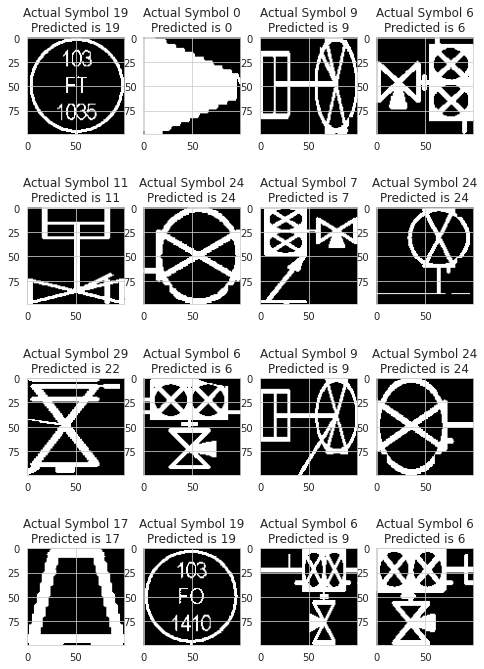

In [28]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 100, 100)

fig, axis = plt.subplots(4, 4, figsize=(8, 12))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Actual Symbol {y_test[i].argmax()}\nPredicted is {y_pred[i].argmax()}");


# New chapter

## Crop image to smaller parts

In [29]:
ls

 CNN_Eng_Drawings.ipynb
 CNN_Eng_Drawings_updated.ipynb
 data/
 edge_image.png
 general_categories
 img_output_circles.jpg
 Line_detection_PID_digitization.ipynb
 lines_offset_ver_hor_5dpi30x21.png
 model.png
 output1.jpg
 realpars_p_id_diag_mod.png
 references.bib
'Spot circles and OCR text in circles.ipynb'


In [30]:
img_path = 'realpars_p_id_diag_mod.png'
img = cv2.imread(img_path, 1)
img_orig = img.copy()

In [31]:
# height, width, depth and ratio
h, w, d = img.shape
resized_w = 800
ratio = resized_w / w

# resize image
resized = imutils.resize(img, width=resized_w)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# blurr the image
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Identify circles
all_circles = cv2.HoughCircles(
    blur,
    method=cv2.HOUGH_GRADIENT,
    dp=0.1,
    minDist=10,
    param1=20,
    param2=10,
    minRadius=11,
    maxRadius=12,
)
circles = np.uint16(np.around(all_circles))
print(str(circles.shape[1]) + " circles found on the PID")

23 circles found on the PID


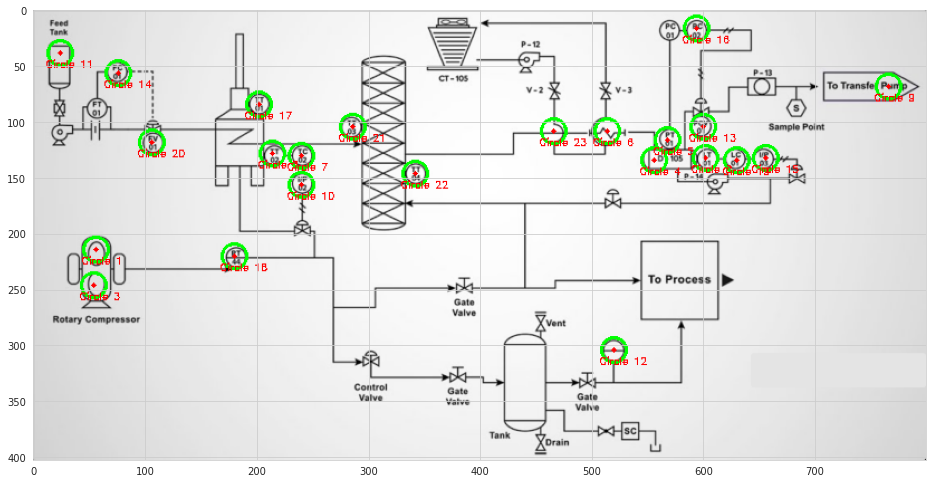

In [32]:
count = 1
img_circles = resized.copy()
for circle in circles[0]:
    # Annotate circle and centroid
    cv2.circle(img_circles, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
    cv2.circle(img_circles, (circle[0], circle[1]), 2, (255, 0, 0), -2)

    # Annotate text
    offset_txt = int(circle[2] * 1.2)
    cv2.putText(
        img_circles,
        "Circle " + str(count),
        (circle[0] - offset_txt, circle[1] + offset_txt),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.3,
        (255, 0, 0),
        1,
    )
    count += 1
plt.rcParams['figure.figsize'] = (16,9)
plt.imshow(img_circles)
plt.show()

In [33]:
circles[0][0]

array([ 56, 214,  11], dtype=uint16)

In [34]:
for idx, i in enumerate(circles[0]):
    print(idx, i[2])

0 11
1 11
2 11
3 11
4 11
5 11
6 11
7 11
8 11
9 11
10 11
11 11
12 11
13 11
14 11
15 11
16 11
17 11
18 11
19 11
20 11
21 11
22 11


In [35]:
plt.imshow(img_circle_txt)
plt.show()

NameError: name 'img_circle_txt' is not defined

In [ ]:
circles[0][0]

In [ ]:
radius=50
plt.imshow(img_circle_txt[circles[0][0][1]-radius:circles[0][0][1]+radius,
           circles[0][0][0]-radius:circles[0][0][0]+radius])

In [ ]:
radius = np.uint16(circles[0][0][2]*.75)

plt.imshow(img_circle_txt[circles[0][0][1]-radius:circles[0][0][1]+radius, 
               circles[0][0][0]-radius:circles[0][0][0]+radius])

In [ ]:
# OCR
import re

cropped_imgs = []
cropped_imgs_txt = []

img_circle_txt = img_orig.copy()

for idx, i in enumerate(circles[0]):
    radius = np.uint16(i[2]*.75)
#     print(radius)
    cropped_img_lower = img_circle_txt[i[1]:i[1]+radius,
                                       i[0]-radius:i[0]+radius]
    cropped_img_upper = img_circle_txt[i[1]-radius:i[1],
                                       i[0]-radius:i[0]+radius]
#     cropped_img = cv2.threshold(cropped_img, 100, 255, cv2.THRESH_BINARY)
    cropped_imgs.append(np.append(cropped_img_upper,
                                  cropped_img_lower, 
                                  axis=0))
# for i in range(len(cropped_imgs)):
for i in range(4):
    plt.imshow(cropped_imgs[i])
    plt.show()

In [ ]:
# OCR
import re

cropped_imgs = []
cropped_imgs_txt = []

img_circle_txt = img_orig.copy()

for idx, i in enumerate(circles[0]):
    radius = i[2]
    cropped_img_lower = img_circle_txt[i[1]:i[1]+radius,
                                       i[0]-radius:i[0]+radius]
    cropped_img_upper = img_circle_txt[i[1]-radius:i[1],
                                       i[0]-radius:i[0]+radius]
#     cropped_img = cv2.threshold(cropped_img, 100, 255, cv2.THRESH_BINARY)
    cropped_imgs.append(np.append(cropped_img_upper,
                                  cropped_img_lower, 
                                  axis=0))
# for i in range(len(cropped_imgs)):
for i in range(4):
    plt.imshow(cropped_imgs[i])
    plt.show()